# Decision Tree - DecisionTreeClassifier

## Index

1. [Setup](#1-Setup)
2. [Data Analysis](#2-Data-Analysis)
3. [scikit-learn: `DecisionTreeClassifier`](#3-scikit-learn-DecisionTreeClassifier)
4. [scikit-learn: `plot_tree`](#4-scikit-learn-plot-tree)

## Objective

1. Build decision tree classifier using **scikit-learn: `DecisionTreeClassifier`**.
2. Visualize decision tree using **scikit-learn: `plot_tree`**.

<a id="1-Setup"></a>
# [1] Setup

### Import and configure required libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
from prettytable import PrettyTable

# Data modeling libraries.
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# General imports
import math

# Library versions.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("PrettyTable version:", prettytable.__version__)
print("Sklearn version:", sklearn.__version__)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

NumPy version: 1.21.5
Pandas version: 1.4.3
PrettyTable version: 3.3.0
Sklearn version: 1.1.1


#### Load data-points from the `.csv` file

In [2]:
wthr_df = pd.read_csv("../input/simple-weather-forecast/weather_forecast.csv")
wthr_df.head(14)

,Outlook,Temperature,Humidity,Windy,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


<a id="2-Data-Analysis"></a>
# [2] Data Analysis

In [3]:
rows, cols = wthr_df.shape
print("Rows:", rows, "Columns:", cols)

Rows: 14 Columns: 5


`DataFrame` metadata:

In [4]:
wthr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     object
 2   Humidity     14 non-null     object
 3   Windy        14 non-null     object
 4   Play         14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


**Observations**

1. Dataset contains **14 rows and 5 columns**.
2. All five columns in 14 rows have `non-null` values. **No missing data**.
3. All the columns contain data in **string data-type**.
4. All the columns are **categorical features**.

#### Distinct values in each feature

In [5]:
table = PrettyTable(["Features", "Distinct Values", "Count"], align="l")

for feature in wthr_df.columns[0:-1]:
    unq_vals = wthr_df[feature].unique().tolist()
    table.add_row([feature, ", ".join(unq_vals), len(unq_vals)])

print(table)

+-------------+-----------------------+-------+
| Features    | Distinct Values       | Count |
+-------------+-----------------------+-------+
| Outlook     | Sunny, Overcast, Rain | 3     |
| Temperature | Hot, Mild, Cool       | 3     |
| Humidity    | High, Normal          | 2     |
| Windy       | Weak, Strong          | 2     |
+-------------+-----------------------+-------+


#### Class label

In [6]:
wthr_df["Play"].value_counts()

Yes    9
No     5
Name: Play, dtype: int64

**Observations**

1. Dataset is **slightly imbalanced**.
2. Dataset contains **64% positive data-points** i.e., Play == "Yes". Positive data-points are **Majority class**.
3. Dataset contains **36% negative data-points** i.e., Play == "No". Negative data-points are **Minority class**.

### How Imbalanced dataset affects Decision Tree?

Imbalanced dataset impacts Entropy/MSE calculation.

#### Solution

Solution to above problem is either **Up-sampling** or **Down-sampling**. In this case Up-sampling is better than Down-sampling since the dataset is too small.

### Up-sampling the Minority class

Up-sampling dataset by duplicating last four rows in the dataset.

In [7]:
# Filter to fetch all minority class values.
fltr = wthr_df["Play"] == "No"

# Apply filter and slice out last four rows.
last_four_rows = wthr_df.loc[fltr][-4:]

# Append last four rows of original DataFrame into a new DataFrame.
wthr_dfb = pd.concat([wthr_df, last_four_rows], ignore_index=True)

# Sort by `Play` column to check the concatenation.
wthr_dfb.sort_values(by=["Play"], ascending=False)

,Outlook,Temperature,Humidity,Windy,Play
9,Rain,Mild,Normal,Weak,Yes
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
6,Overcast,Cool,Normal,Strong,Yes
8,Sunny,Cool,Normal,Weak,Yes
10,Sunny,Mild,Normal,Strong,Yes
11,Overcast,Mild,High,Strong,Yes
12,Overcast,Hot,Normal,Weak,Yes
13,Rain,Mild,High,Strong,No


In [8]:
# Verify if dataset is balanced.
wthr_dfb["Play"].value_counts()

No     9
Yes    9
Name: Play, dtype: int64

Now the dataset is balanced!

<a id="3-scikit-learn-DecisionTreeClassifier"></a>
# [3] scikit-learn: `DecisionTreeClassifier`

Split dataset into `X_train` and `y_train`.

In [9]:
X_train = wthr_dfb[["Outlook", "Temperature", "Humidity", "Windy"]]
y_train = wthr_dfb["Play"]

Encode categorical data to numerical data.

In [10]:
le = LabelEncoder()

X_train = X_train.apply(le.fit_transform)
y_train = le.fit_transform(y_train)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (18, 4)
y_train shape: (18,)


Train a decision tree classifier.

In [11]:
clf = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)

<a id="4-scikit-learn-plot-tree"></a>
# [4] scikit-learn: `plot_tree`

### Plot Decision Tree

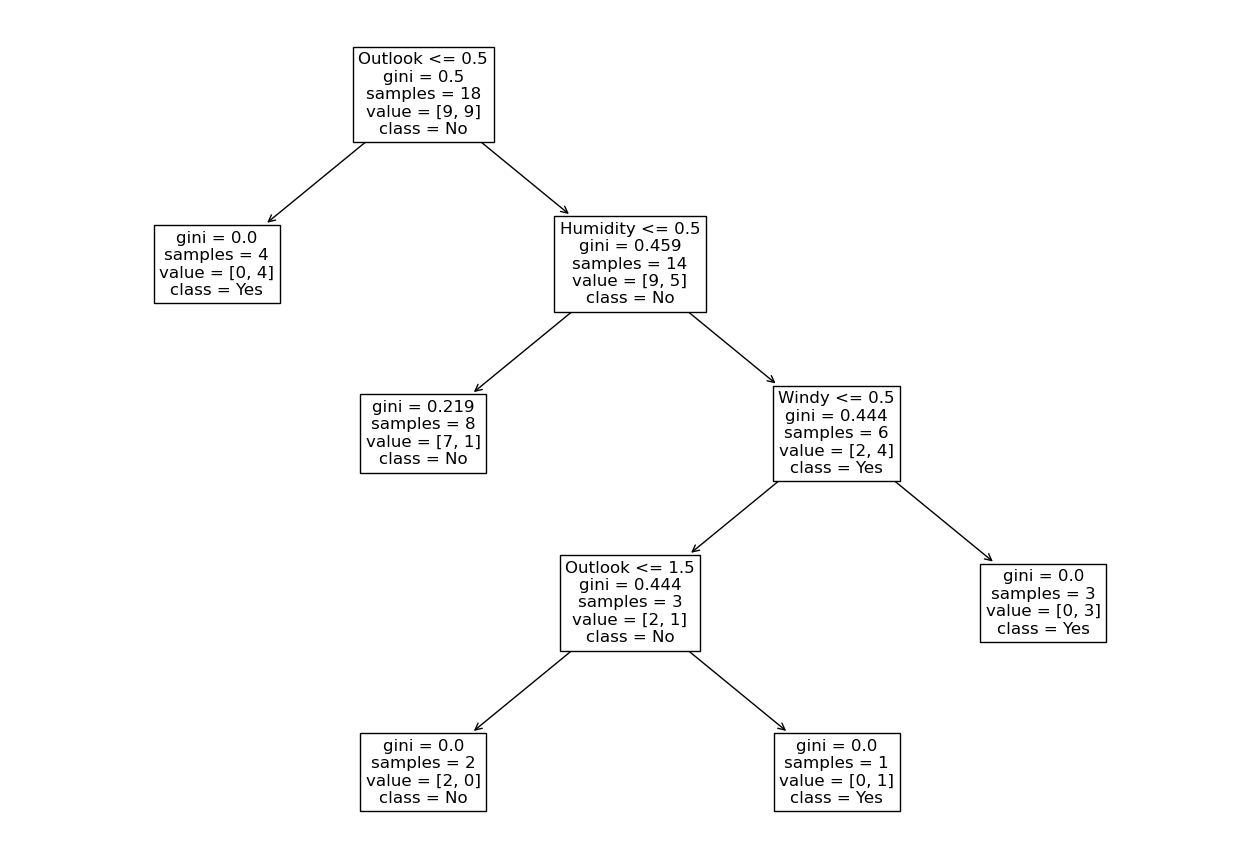

In [12]:
fig = plt.figure(figsize=(16, 11))  # Figsize: Width, Height
tree.plot_tree(clf, feature_names=X_train.columns.tolist(), class_names=["No", "Yes"], fontsize=12)
plt.show()

#### Feature Importance

In [13]:
# Feature importance.
fi = np.around(clf.feature_importances_, 4).tolist()

# Feature names.
ft = X_train.columns.tolist()

table = PrettyTable(["Name", "Importance"], align="l")
table.add_rows(zip(ft, fi))
print(table)

+-------------+------------+
| Name        | Importance |
+-------------+------------+
| Outlook     | 0.5386     |
| Temperature | 0.0        |
| Humidity    | 0.2775     |
| Windy       | 0.1839     |
+-------------+------------+
